In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys

!git clone -b recovery5 https://github.com/wjteng/LBC-IoT-Key-Recovery.git

sys.path.insert(0,'/content/LBC-IoT-Key-Recovery')

import numpy as np
from os import urandom
import lbciot as cipher
import pandas as pd
import train_nets as tn

rounds = 5;
epoch = 40;
diff1 = 0x0040;
diff2 = 0x0000;

name = str(diff1)+"_"+str(diff2)+"_r="+str(rounds)+"_epoch="+str(epoch);

model, h =tn.train_distinguisher(epoch,(diff1,diff2),num_rounds=rounds,depth=10);

model.save('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name);

Mounted at /content/gdrive/
Cloning into 'LBC-IoT-Key-Recovery'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 100 (delta 51), reused 91 (delta 46), pack-reused 0
Receiving objects: 100% (100/100), 247.62 KiB | 3.99 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Epoch 1/40
200/200 [==============================] - 39s 107ms/step - loss: 0.2556 - acc: 0.5335 - val_loss: 0.2560 - val_acc: 0.5350 - lr: 0.0020
Epoch 2/40
200/200 [==============================] - 21s 104ms/step - loss: 0.1925 - acc: 0.7088 - val_loss: 0.2245 - val_acc: 0.6633 - lr: 0.0018
Epoch 3/40
200/200 [==============================] - 21s 104ms/step - loss: 0.1198 - acc: 0.8482 - val_loss: 0.1245 - val_acc: 0.8377 - lr: 0.0016
Epoch 4/40
200/200 [==============================] - 21s 104ms/step - loss: 0.0944 - acc: 0.8874 - val_loss: 0.0954 - val_acc: 0.8861 - lr: 0.0014
Epoch 5/40
200/200 [==============

0
10000
20000
30000
40000
50000
60000


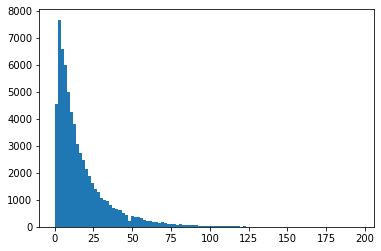

found max:19271
correct key:19271
[[19271   196]
 [19015   189]
 [19287   189]
 [23367   183]
 [19031   180]
 [23111   176]
 [23383   176]
 [ 2887   171]
 [18759   170]
 [23127   168]
 [ 2903   164]
 [18503   164]
 [19399   164]
 [18775   163]
 [ 2631   161]
 [19267   161]
 [ 2647   160]
 [18519   159]
 [19143   159]
 [ 6983   157]
 [19011   157]
 [22855   157]
 [19283   156]
 [19415   156]
 [ 6727   153]
 [19159   153]
 [ 6999   152]
 [22871   152]
 [23495   151]
 [ 6743   150]]


In [ ]:

n = 200; #number of plaintext pairs

rounds = 5;
epoch = 40;
diff1 = 0x0040;
diff2 = 0x0000;

key = np.frombuffer(urandom(10),dtype=np.uint16).reshape(5,-1);
keys = np.frombuffer(urandom(10*n),dtype=np.uint16).reshape(5,-1)*0+1 ;


for i in range(0,n):
  for j in range(0,5):
    keys[j][i]=key[j];


pt0l = np.frombuffer(urandom(2*n),dtype=np.uint16);
pt0r = np.frombuffer(urandom(2*n),dtype=np.uint16);

p0l = np.copy(pt0l); 
p0r = np.copy(pt0r);

p1l = p0l^diff1;
p1r = p0r^diff2;

ks = cipher.expand_key(keys, rounds + 1);

c0l,c0r = cipher.encrypt((p0l,p0r),ks);
c1l,c1r = cipher.encrypt((p1l,p1r),ks);



from tensorflow import keras

name = str(diff1)+"_"+str(diff2)+"_r="+str(rounds)+"_epoch="+str(epoch);
model = keras.models.load_model('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name);

allkeys = ks[rounds]*0;

count = np.zeros(2**16,dtype=int);

for i in range(0,2**16):
  if i%10000==0:
    print(i);
  c0l_dec1,c0r_dec1 = cipher.dec_one_round((c0l,c0r),allkeys);
  c1l_dec1,c1r_dec1 = cipher.dec_one_round((c1l,c1r),allkeys);
  X = cipher.convert_to_binary([c0l_dec1,c0r_dec1,c1l_dec1,c1r_dec1]);
  Z = model.predict(X,batch_size=10000);
  count[allkeys[0]] =  np.sum(Z>0.5);
  allkeys = allkeys + 1;

df = pd.DataFrame(count);
df.to_csv('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+'count_'+str(diff1)+'_'+str(diff2)+'.csv');

import matplotlib.pyplot as plt

plt.hist(count, bins=100)
plt.savefig('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name+'_counthist.png')
plt.show()


count[np.argmax(count)]
print('found max:'+str(np.argmax(count)))
print('correct key:'+str(ks[rounds][0]));
count[41855]
sorted_count = -np.sort(-count);
temp = count;
top = 30;
rank = np.zeros((top,2),dtype=int);
for i in range(0,top):
  max_index = np.argmax(temp);
  rank[i][0] = max_index;
  rank[i][1] = temp[max_index];
  temp[max_index]=-1;

print(rank);

count[np.argmax(count)]
print('found max:'+str(np.argmax(count)))
print('correct key:'+str(ks[rounds][0]));
count[41855]
sorted_count = -np.sort(-count);
temp = count;
top = 10;
rank = np.zeros((top,2),dtype=int);
for i in range(0,top):
  max_index = np.argmax(temp);
  rank[i][0] = max_index;
  rank[i][1] = temp[max_index];
  temp[max_index]=-1;

print(rank);  



NameError: ignored